In [1]:
import sys
sys.path.append('../') # This adds the main project folder to Python's path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.preprocess import load_and_preprocess_data

# Set plot style
sns.set_style('whitegrid')

# Define the relative path to the data
path_to_data = '../data'

# Load the master dataframe using our function
master_df = load_and_preprocess_data(path_to_data)

# Display the info to confirm it loaded correctly
master_df.info()

✅ Data loading and preprocessing complete.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  int64         
 9   product_id                     112650 non-null  object        
 10  seller_id                

In [2]:
# Set the purchase timestamp as the index of the dataframe
df_time = master_df.set_index('order_purchase_timestamp')

# Resample the data by day ('D') and calculate the sum of 'price' for each day
daily_sales = df_time['price'].resample('D').sum()

# The resampling might create days with no sales. Let's fill those with 0.
daily_sales = daily_sales.fillna(0)

# Display the first 10 days of our new time series
print("--- Daily Sales Time Series ---")
print(daily_sales.head(10))

--- Daily Sales Time Series ---
order_purchase_timestamp
2016-09-04    72.89
2016-09-05    59.50
2016-09-06     0.00
2016-09-07     0.00
2016-09-08     0.00
2016-09-09     0.00
2016-09-10     0.00
2016-09-11     0.00
2016-09-12     0.00
2016-09-13     0.00
Freq: D, Name: price, dtype: float64


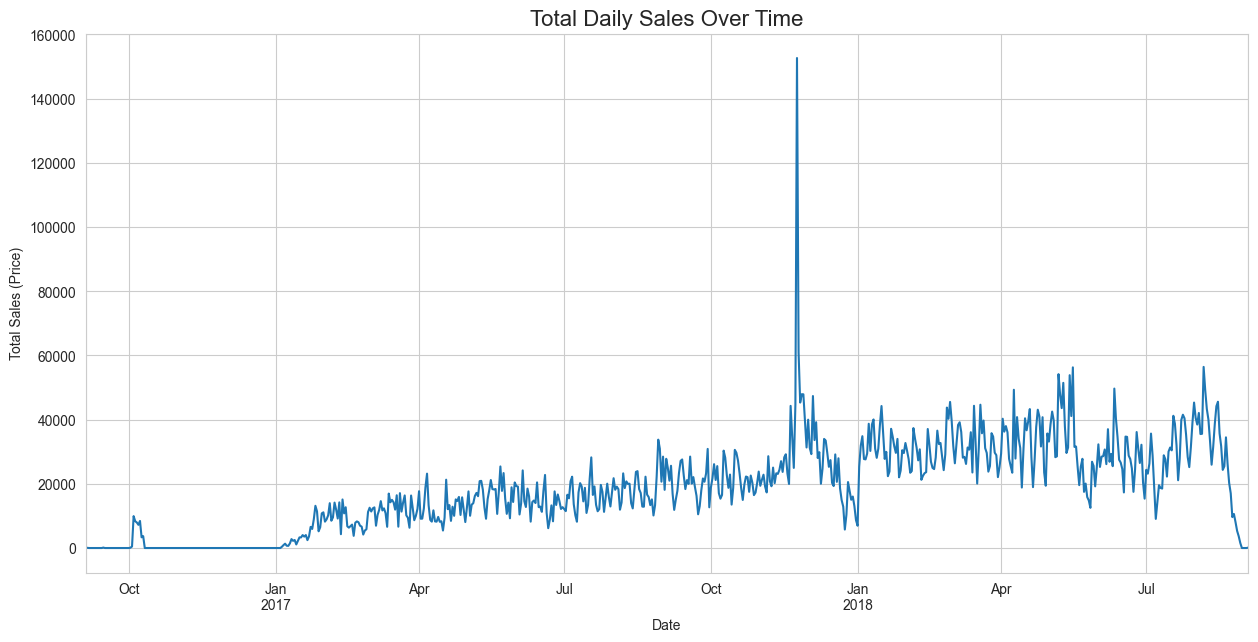

In [3]:
# Create a plot of daily sales over time
plt.figure(figsize=(15, 7))
daily_sales.plot()
plt.title('Total Daily Sales Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Sales (Price)')
plt.show()

In [4]:
# Our data runs until late 2018. Let's use the last 3 months for testing.
split_date = '2018-06-01'

train_data = daily_sales.loc[daily_sales.index <= split_date]
test_data = daily_sales.loc[daily_sales.index > split_date]

print(f"Training data runs from {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing data runs from {test_data.index.min()} to {test_data.index.max()}")

Training data runs from 2016-09-04 00:00:00 to 2018-06-01 00:00:00
Testing data runs from 2018-06-02 00:00:00 to 2018-09-03 00:00:00


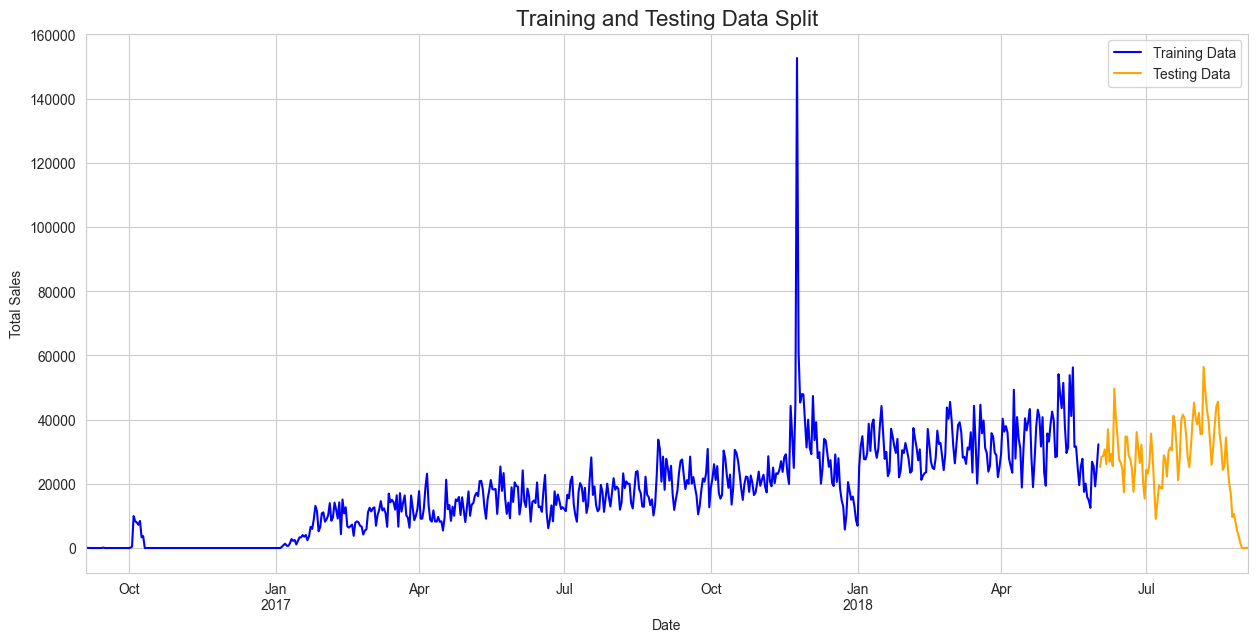

In [5]:
plt.figure(figsize=(15, 7))

# Plot training and testing data
train_data.plot(label='Training Data', color='blue')
test_data.plot(label='Testing Data', color='orange')

plt.title('Training and Testing Data Split', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

In [6]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [8]:
import xgboost as xgb

# --- 1. Create a DataFrame of Features from the Time Series Index ---
features_df = pd.DataFrame(index=daily_sales.index)
features_df['dayofweek'] = features_df.index.dayofweek
features_df['quarter'] = features_df.index.quarter
features_df['month'] = features_df.index.month
features_df['year'] = features_df.index.year
features_df['dayofyear'] = features_df.index.dayofyear

# Our "X" is the DataFrame of features
X = features_df

# Our "y" is the target variable we want to predict (daily sales)
y = daily_sales

# --- 2. Split the Features (X) and Target (y) into Train/Test Sets ---
split_date = '2018-06-01'

X_train = X.loc[X.index <= split_date]
y_train = y.loc[y.index <= split_date]

X_test = X.loc[X.index > split_date]
y_test = y.loc[y.index > split_date]

print("--- Feature DataFrame Head ---")
print(X_train.head())

# --- 3. Train the XGBoost Model (this part is the same as before) ---
reg = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    objective='reg:squarederror'
)

print("\n--- Training the XGBoost Model ---")
reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)
print("✅ Model training complete.")

--- Feature DataFrame Head ---
                          dayofweek  quarter  month  year  dayofyear
order_purchase_timestamp                                            
2016-09-04                        6        3      9  2016        248
2016-09-05                        0        3      9  2016        249
2016-09-06                        1        3      9  2016        250
2016-09-07                        2        3      9  2016        251
2016-09-08                        3        3      9  2016        252

--- Training the XGBoost Model ---
[0]	validation_0-rmse:13746.76964	validation_1-rmse:15775.41015
[100]	validation_0-rmse:7107.90151	validation_1-rmse:13569.16850
[200]	validation_0-rmse:4582.79870	validation_1-rmse:12791.98965
[300]	validation_0-rmse:3478.03164	validation_1-rmse:12339.68225
[400]	validation_0-rmse:2884.55670	validation_1-rmse:12161.97675
[500]	validation_0-rmse:2566.97057	validation_1-rmse:12139.24573
[600]	validation_0-rmse:2365.65250	validation_1-rmse:12121.15

In [9]:
# Use the trained model to make predictions on the test set
test_data['prediction'] = reg.predict(X_test)

# Display the test data with the new 'prediction' column
print(test_data.head())

order_purchase_timestamp
2018-06-02 00:00:00    25266.62
2018-06-03 00:00:00    28461.66
2018-06-04 00:00:00     28622.4
2018-06-05 00:00:00    30709.36
2018-06-06 00:00:00     26134.4
Name: price, dtype: object


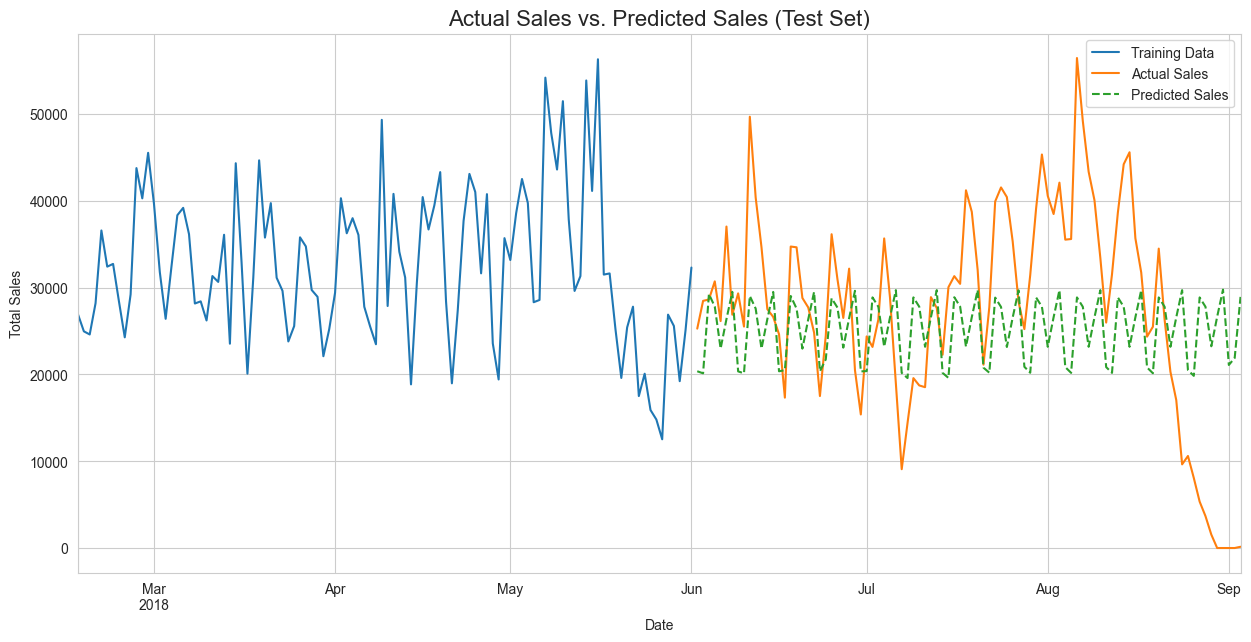

Root Mean Squared Error (RMSE): 12116.96
Mean Absolute Percentage Error (MAPE): 476000817192975859712.00%


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# --- 1. Make Predictions and Create a Clean Prediction Series ---
# Get the raw prediction values from the model
prediction_values = reg.predict(X_test)

# Create a new pandas Series for our predictions, using the same index as our test data
predictions = pd.Series(prediction_values, index=y_test.index)


# --- 2. Combine Data for Visualization ---
# Concatenate the original, clean Series and rename them for the plot legend
all_data = pd.concat([
    train_data.rename('Training Data'),
    y_test.rename('Actual Sales'),
    predictions.rename('Predicted Sales')
], axis=1)


# --- 3. Visualize the Forecast ---
plt.figure(figsize=(15, 7))
all_data.tail(200).plot(
    ax=plt.gca(),
    style=['-', '-', '--']
)
plt.title('Actual Sales vs. Predicted Sales (Test Set)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()


# --- 4. Calculate Error Metrics using Clean Data ---
# Now we compare the original test data (y_test) with our predictions
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

mape = mean_absolute_percentage_error(y_test, predictions)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# Create a clean Series for the predictions
prediction_values = reg.predict(X_test)
predictions = pd.Series(prediction_values, index=y_test.index)

# --- Calculate Standard Metrics ---
# 1. Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# 2. Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae:.2f}")


# --- Calculate Corrected MAPE (excluding zero-sale days) ---
# Create a temporary dataframe to filter out zero-sale days
temp_df = pd.DataFrame({'actual': y_test, 'predicted': predictions})
temp_df = temp_df[temp_df['actual'] > 0]

# Calculate MAPE only on the days where there were sales
corrected_mape = mean_absolute_percentage_error(temp_df['actual'], temp_df['predicted'])
print(f"Corrected Mean Absolute Percentage Error (MAPE): {corrected_mape:.2%}")

Root Mean Squared Error (RMSE): 12116.96
Mean Absolute Error (MAE): 9613.52
Corrected Mean Absolute Percentage Error (MAPE): 276.87%
